## Figure: Agreement and Recource

In [1]:
#%%
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging

from mono_multi.setup import (
    PAPER_TASKS,
    FIGURES_ROOT_DIR,
)
from mono_multi.utils import (
    cumulative_sum,
    load_model_outputs_same_prompt,
    load_results_overview,
    add_evals_to_df,
    load_data_if_needed,
    filter_results_all_tasks,
    add_newline_camelcase
)

from mono_multi.plotting import (
    plot_recourse_wrapper,
    plot_agreement_wrapper,
    configure_legend,
)

import numpy as np 
import pandas as pd
from mono_multi.metrics import get_observed_pairwise_agreement_rate, matrix_pairwise_evals


/Users/mgorecki/opt/miniconda3/envs/monoc-py311/lib/python3.11/site-packages/xport/__about__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [ ]:
plot_config_file = "./results/.matplotlibrc"
plt.rcParams.update(mpl.rc_params_from_file(fname=plot_config_file))

FIGURES_PAPER_DIR = FIGURES_ROOT_DIR / "same-prompt"
TASKS = PAPER_TASKS  

In [4]:
select_by = "accuracy"  #'balanced_accuracy' #
fit_threshold_for = "balanced_accuracy" #'accuracy' #

## Load Task Data

In [5]:
try:
    data_all
except NameError:
    print("'data_all' not yet defined")
    data_all = load_data_if_needed(data=None, tasks=TASKS)
else:
    print("Already defined, update if needed.")
    data_all = load_data_if_needed(data=data_all, tasks=TASKS)

'data_all' not yet defined
ACSIncome
ACSEmployment


BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility


## Load predictions

In [6]:
num_shots = 0
threshold_fitted = True

df = load_results_overview(
    num_shots=num_shots, threshold_fitted=threshold_fitted, same_prompt=True
)
df = df[df["task"].isin(TASKS)]
df = df[df["correct_order_bias"] == 0]
if threshold_fitted and ("threshold_obj" in df.columns):
    df = df[df["threshold_obj"] == fit_threshold_for]

df["predictions_path"] = "/Volumes/mgorecki/monoculture/" + df["predictions_path"]

df.shape

(349, 19)

In [7]:
try:
    assert set(TASKS).issubset(
        set(df["task"].unique())
    ), f"Results for all tasks to be analysed have to be available, available are: {list(df['task'].unique())} "
except AssertionError:
    TASKS = list(df["task"].unique())
    logging.warning(f"Reduced TASKS to available tasks: {TASKS}")

In [8]:
predictions_all = load_model_outputs_same_prompt(
    df, tasks=TASKS, return_risk_scores=False
)

df = add_evals_to_df(df)

ACSIncome
ACSEmployment
BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility


## Restrict analysis to models based on performance or true labels?

In [9]:
restrict_to_better_const = False
restrict_to_positive_label = True
restrict_to_negative_label = False
restrict_to_top_eps = True
eps = 0.05
restrict_to_topk = False
topk = 10

predictions, data = filter_results_all_tasks(
    predictions=predictions_all.copy(),
    df=df,
    data={t: val for t, val in data_all.items() if t in TASKS},
    tasks=TASKS,
    restrict_to_better_const=restrict_to_better_const,
    restrict_to_positive_label=restrict_to_positive_label,
    restrict_to_negative_label=restrict_to_negative_label,
    restrict_to_top_eps=restrict_to_top_eps,
    restrict_to_topk=restrict_to_topk,
    eps=eps,
    topk=topk,
    acc=select_by,
)

ACSIncome
- before: (166450, 50)
- after: (61233, 27)
ACSEmployment
- before: (323611, 50)
- after: (146740, 8)
BRFSS_Blood_Pressure
- before: (84676, 50)
- after: (44586, 23)
SIPP
- before: (3972, 49)
- after: (2035, 16)
ACSTravelTime
- before: (146665, 50)
- after: (64285, 12)
ACSPublicCoverage
- before: (113829, 50)
- after: (33971, 21)
ACSMobility
- before: (62094, 50)
- after: (16446, 5)


## Plot

In [10]:
# helpers
def build_filename(name: str):
    parts = [
        f"{name}-{num_shots}-shot",
        (
            f"_selected_by-{select_by.replace('_','-')}"
            f"_tresh_fitted-{fit_threshold_for.replace('_','-')}"
            if threshold_fitted
            else ""
        ),
        "_better_const" if restrict_to_better_const else "",
        "_pos_instances" if restrict_to_positive_label else "",
        "_neg_instances" if restrict_to_negative_label else "",
        f"_eps{str(eps).replace('.', '_')}" if restrict_to_top_eps else "",
        f"_top{topk}" if restrict_to_topk else "",
    ]
    return "".join(parts)

### Agreement and Recourse in one figure

ACSIncome
mean agreement: 0.8837
mean agreement at random: 0.6366
ACSEmployment
mean agreement: 0.8829
mean agreement at random: 0.6639
BRFSS_Blood_Pressure
mean agreement: 0.7243
mean agreement at random: 0.5223
SIPP
mean agreement: 0.8429
mean agreement at random: 0.6294
ACSTravelTime
mean agreement: 0.7430
mean agreement at random: 0.5260
ACSPublicCoverage
mean agreement: 0.6895
mean agreement at random: 0.5832
ACSMobility
mean agreement: 0.8640
mean agreement at random: 0.5946
agreement-recourse-0-shot_selected_by-accuracy_tresh_fitted-balanced-accuracy_pos_instances_eps0_05


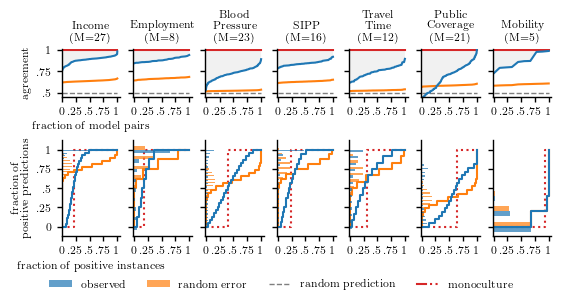

In [11]:
tasks_to_plot = PAPER_TASKS

fig_width = 1*plt.rcParams["figure.figsize"][0]  # 3*plt.rcParams["figure.figsize"][0]
fig_height = 0.9*plt.rcParams["figure.figsize"][1]

fig, axs = plt.subplots(
    2,
    len(tasks_to_plot),
    figsize=(fig_width, fig_height),
    sharey="row",
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1, 2]},
)

recourse_observed = {}
recourse_at_random = {}
agreement = {}

for i, task in enumerate(tasks_to_plot):
    print(task)
    M = len(predictions[task].columns)
    mask = (df["task"] == task) & (df["model"].isin(predictions[task].columns))

    # agreement
    axs[0, i], agreement_data = plot_agreement_wrapper(
        axs[0, i],
        predictions=predictions[task],
        df=df[mask],
        xlabel="",
        ylabel="",
    )
    print(f"mean agreement: {agreement_data['observed'].agreement.mean():.4f}")
    print(
        f"mean agreement at random: {agreement_data['baseline'].agreement.mean():.4f}"
    )
    agreement[task] = agreement_data

    # recourse
    axs[1, i], observed, at_random = plot_recourse_wrapper(
        axs[1, i],
        predictions=predictions[task],
        df=df[mask],
        count_accepted=restrict_to_positive_label,
        baseline_metric = 'tpr' if restrict_to_positive_label else 'tnr',
        xlabel="",
        ylabel="",
    )

    recourse_observed[task] = observed
    recourse_at_random[task] = at_random

    axs[0, i].set_title(
        f"{add_newline_camelcase(task.replace('ACS', '').replace('BRFSS', '').replace('_', ''))}\n(M={M})"
    )

axs[0, 0].set_ylabel("agreement")
axs[0,0].set_xlabel("fraction of model pairs")

axs[1, 0].set_ylabel(f"fraction of\n {'positive' if restrict_to_positive_label else 'negative'} predictions")
axs[1, 0].set_xlabel(f"fraction of {'positive' if restrict_to_positive_label else 'negative'} instances")#, loc='left')
configure_legend(fig, axs, offset=0.2)

file_name = build_filename(name="agreement-recourse")
for ending in [".svg", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"fig2_{file_name}{ending}")
print(file_name)

plt.show()

#### Recourse Stats

In [12]:
agreement_df = []
agree_matrix = matrix_pairwise_evals(data=predictions['ACSPublicCoverage'], fun=get_observed_pairwise_agreement_rate)
for i, m1 in enumerate(predictions['ACSPublicCoverage'].columns):
    for j, m2 in enumerate(predictions['ACSPublicCoverage'].columns): 
        if j<i and agree_matrix[i,j] < agree_matrix[~np.isnan(agree_matrix)].mean():
            agreement_df.append({'m1': m1, 'm2': m2, 'agreement': agree_matrix[i,j]})
agreement_df = pd.DataFrame.from_dict(agreement_df)
agreement_df.sort_values(by='agreement')

,m1,m2,agreement
101,mistralai--Mixtral-8x22B-Instruct-v0.1,allenai--OLMo-1B-0724-hf,0.407524
102,mistralai--Mixtral-8x22B-Instruct-v0.1,meta-llama--Meta-Llama-3.2-1B-Instruct,0.407642
104,mistralai--Mixtral-8x22B-Instruct-v0.1,google--gemma-7b,0.433164
103,mistralai--Mixtral-8x22B-Instruct-v0.1,allenai--OLMo-7B-hf,0.437579
84,Qwen--Qwen2.5-72B-Instruct,meta-llama--Meta-Llama-3.2-1B-Instruct,0.438551
...,...,...,...
99,mistralai--Mixtral-8x22B-v0.1,Qwen--Qwen2-72B,0.714433
16,google--gemma-2-9b-it,allenai--OLMo-7B-0724-hf,0.714727
81,Qwen--Qwen2-72B-Instruct,meta-llama--Meta-Llama-3-8B-Instruct,0.715081
62,meta-llama--Meta-Llama-3-70B-Instruct,Qwen--Qwen2.5-7B-Instruct,0.715551


In [13]:
rec = recourse_observed['ACSPublicCoverage']
frac_models = rec[:, 1]
frac_ind = rec[:, 0]

rec_cum = np.vstack([cumulative_sum(frac_ind), frac_models]).T
rec_cum#[rec_cum[:,0]>=0.3]

array([[0.13950134, 0.        ],
       [0.23799712, 0.04761905],
       [0.31182479, 0.0952381 ],
       [0.36943275, 0.14285714],
       [0.41526596, 0.19047619],
       [0.45703688, 0.23809524],
       [0.49109535, 0.28571429],
       [0.5237114 , 0.33333333],
       [0.55573872, 0.38095238],
       [0.58623532, 0.42857143],
       [0.61826264, 0.47619048],
       [0.64955403, 0.52380952],
       [0.68116923, 0.57142857],
       [0.72388213, 0.61904762],
       [0.78043037, 0.66666667],
       [0.84363133, 0.71428571],
       [0.95525595, 0.76190476],
       [0.99676194, 0.80952381],
       [0.99997056, 0.85714286],
       [1.        , 0.9047619 ]])

In [14]:
import numpy as np

output = f"{'task':20} &   M  & \tno recourse & substantial recourse & full recourse\\\\"

for task in recourse_observed.keys():
    M = predictions[task].shape[1]
    rec = recourse_observed[task]
    frac_models = rec[:, 1]
    frac_ind = rec[:, 0]
    max_frac_no_rec = (
        sum(frac_ind[frac_models == 0.0]) if sum(frac_models == 0.0) > 0 else 0.0
    )
    frac_limited_rec = (
        sum(frac_ind[frac_models <= 0.5]) if sum(frac_models <= 0.5) > 0 else 0.0
    )
    frac_substantial_rec = 1 - frac_limited_rec
    frac_full_rec = (
        sum(frac_ind[np.isclose(frac_models, 1.0)])
        if sum(np.isclose(frac_models, 1.0)) > 0
        else 0.0
    )
    output += (
        f"\n{task.replace('_', ' '):20} & {M:3}  &\t{max_frac_no_rec:.2f}"
        f"&\t{frac_substantial_rec:.2f}"
        f"&\t{frac_full_rec:.2f}\\\\"
    )

print(output)

with open(FIGURES_PAPER_DIR / (build_filename("recourse_table") + ".txt"), "w") as file:
    file.write(output)

task                 &   M  & 	no recourse & substantial recourse & full recourse\\
ACSIncome            &  27  &	0.07&	0.80&	0.51\\
ACSEmployment        &   8  &	0.06&	0.82&	0.64\\
BRFSS Blood Pressure &  23  &	0.03&	0.60&	0.14\\
SIPP                 &  16  &	0.05&	0.77&	0.48\\
ACSTravelTime        &  12  &	0.04&	0.72&	0.24\\
ACSPublicCoverage    &  21  &	0.14&	0.38&	0.00\\
ACSMobility          &   5  &	0.68&	0.00&	0.00\\


### Only Recourse

ACSIncome
ACSEmployment
BRFSS_Blood_Pressure
SIPP
ACSTravelTime
ACSPublicCoverage
ACSMobility
recourse-0-shot_selected_by-accuracy_tresh_fitted-balanced-accuracy_pos_instances_eps0_05


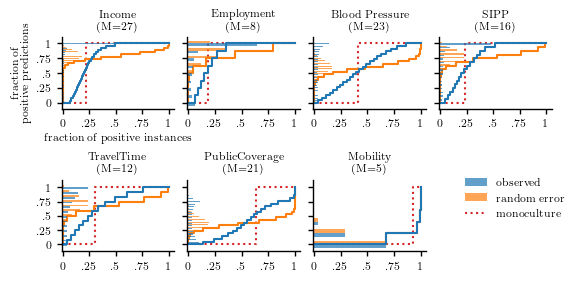

In [15]:
tasks_to_plot = PAPER_TASKS  # [task for task in TASKS if task != 'BRFSS_Diabetes']
num_tasks = len(tasks_to_plot)

fig_width = plt.rcParams["figure.figsize"][0]
fig_height = 0.9 * plt.rcParams["figure.figsize"][1]


r, c = 2, (num_tasks + 1) // 2
fig, axs = plt.subplots(
    r,
    c,
    figsize=(fig_width, fig_height),
    sharey="row",
    constrained_layout=True,
)

recourse_observed = {}
recourse_at_random = {}
for i, ax in enumerate(axs.flat):
    if i < num_tasks:
        task = tasks_to_plot[i]
        print(task)
        M = len(predictions[task].columns)
        mask = (df["task"] == task) & (df["model"].isin(predictions[task].columns))

        ax, observed, at_random = plot_recourse_wrapper(
            ax=ax,
            predictions=predictions[task],
            df = df[mask],
            baseline_metric='tpr',
            xlabel="",
            ylabel="",
        )
        recourse_observed[task] = observed
        recourse_at_random[task] = at_random

        ax.set_title(
            f"{task.replace('ACS', '').replace('BRFSS', '').replace('_', ' ')}\n(M={M})"
        )


axs[0, 0].set_ylabel("fraction of\n positive predictions")
axs[0, 0].set_xlabel("fraction of positive instances")

bbox = axs.flat[-1].get_position()
x_center = (bbox.x0 + bbox.x1) / 2
y_center = (bbox.y0 + bbox.y1) / 2

configure_legend(
    fig,
    axs,
    add_monoculture_mixed_handle=False,
    loc="center left",
    columns=False,
    bbox_to_anchor=(x_center, y_center),
)
axs.flat[-1].axis("off")


file_name = build_filename(name="recourse")
for ending in [".png", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"fig2_{file_name}{ending}")
print(file_name)

plt.show()

### Only Agreement

ACSIncome
mean agreement: 0.8837
mean agreement at random: 0.6366
ACSEmployment
mean agreement: 0.8829
mean agreement at random: 0.6639
BRFSS_Blood_Pressure
mean agreement: 0.7243
mean agreement at random: 0.5223
SIPP
mean agreement: 0.8429
mean agreement at random: 0.6294
ACSTravelTime
mean agreement: 0.7430
mean agreement at random: 0.5260
ACSPublicCoverage
mean agreement: 0.6895
mean agreement at random: 0.5832
ACSMobility
mean agreement: 0.8640
mean agreement at random: 0.5946
agreement-0-shot_selected_by-accuracy_tresh_fitted-balanced-accuracy_pos_instances_eps0_05


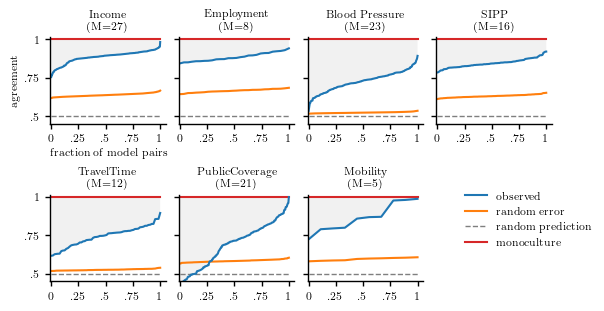

In [16]:
tasks_to_plot = (
    PAPER_TASKS  # [task for task in TASKS if task not in ['ACSHealthInsurance']]
)

fig_width = plt.rcParams["figure.figsize"][0]  # 3*plt.rcParams["figure.figsize"][0]
fig_height = plt.rcParams["figure.figsize"][1]
nrows = 2

fig, axs = plt.subplots(
    nrows,
    (len(tasks_to_plot) + 1) // nrows,
    figsize=(fig_width, fig_height),
    sharey="row",
    constrained_layout=True,
)

recourse_observed = {}
recourse_at_random = {}

for i, ax in enumerate(axs.flat):
    if i < len(tasks_to_plot):
        task = tasks_to_plot[i]
        print(task)
        M = len(predictions[task].columns)
        mask = (df["task"] == task) & (df["model"].isin(predictions[task].columns))

        # agreement
        ax, agreement_data = plot_agreement_wrapper(
            ax, predictions=predictions[task], df=df[mask], xlabel="", ylabel=""
        )
        print(f"mean agreement: {agreement_data['observed'].agreement.mean():.4f}")
        print(
            f"mean agreement at random: {agreement_data['baseline'].agreement.mean():.4f}"
        )

        ax.set_title(
            f"{task.replace('ACS', '').replace('BRFSS', '').replace('_', ' ')}\n(M={M})"
        )

axs[0, 0].set_ylabel("agreement")
axs[0, 0].set_xlabel("fraction of model pairs")
bbox = axs.flat[-1].get_position()
x_center = (bbox.x0 + bbox.x1) / 2
y_center = (bbox.y0 + bbox.y1) / 2

configure_legend(
    fig,
    axs,
    add_monoculture_mixed_handle=False,
    loc="center left",
    columns=False,
    bbox_to_anchor=(x_center, y_center),
)
axs.flat[-1].axis("off")

file_name = build_filename(name="agreement")
for ending in [".png", ".pdf"]:
    plt.savefig(FIGURES_PAPER_DIR / f"fig2_{file_name}{ending}")
print(file_name)

plt.show()